# Modeling Workbook

## Imports and Settings

In [33]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

### Palette codes:

In [15]:
oxford_blue = (10/255, 35/255, 66/255)
timberwolf = (212/255, 210/255, 213/255)
silver = (191/255, 175/255, 166/255)
viridian = (91/255, 130/255, 102/255)
ebony_green = (86/255, 98/255, 70/255)
liver = (119/255, 81/255, 68/255)

full_palette = [oxford_blue, timberwolf, silver, viridian, ebony_green, liver]

___

## Load and Prepare Data

In [16]:
# Reading the data
daily_df = pd.read_csv('../data/clean_data/daily.csv').set_index('id')
daily_df.head()

,date,store_id,store_type,location_type,region_code,holiday,discount,orders,sales
id,,,,,,,,,
T1000001,2018-01-01,1,S1,L3,R1,1,1,9,7011.84
T1000002,2018-01-01,253,S4,L2,R1,1,1,60,51789.12
T1000003,2018-01-01,252,S3,L2,R1,1,1,42,36868.20
T1000004,2018-01-01,251,S2,L3,R1,1,1,23,19715.16
T1000005,2018-01-01,250,S2,L3,R4,1,1,62,45614.52


In [17]:
# process time columns
daily_df['date'] = pd.to_datetime(daily_df['date'])
daily_df['year'] = daily_df['date'].dt.year
daily_df['weekofyear'] = daily_df['date'].dt.isocalendar().week

### Creating the weekly data:

In [18]:
weekly_df = daily_df.groupby(['year', 'weekofyear', 'region_code']).agg(
    sales=("sales", "sum"),
    orders=("orders", "sum"),
    discounts=("discount", "sum"),
    holidays=("holiday", "sum")
    ).reset_index()
weekly_df['week'] = weekly_df['year'].astype(str) + "-" + weekly_df['weekofyear'].astype(str)
weekly_df.head()

,year,weekofyear,region_code,sales,orders,discounts,holidays,week
0,2018,1,R1,52925573.22,73891,674,124,2018-1
1,2018,1,R2,41212947.18,53120,586,105,2018-1
2,2018,1,R3,33846983.79,42500,456,86,2018-1
3,2018,1,R4,19725848.31,24119,266,50,2018-1
4,2018,2,R1,42225337.95,62244,246,124,2018-2


In [19]:
# Check if there are any missing weeks
print(weekly_df.shape[0]//4)
weekly_df.week.nunique()

74


74

### Plot Weekly Data:

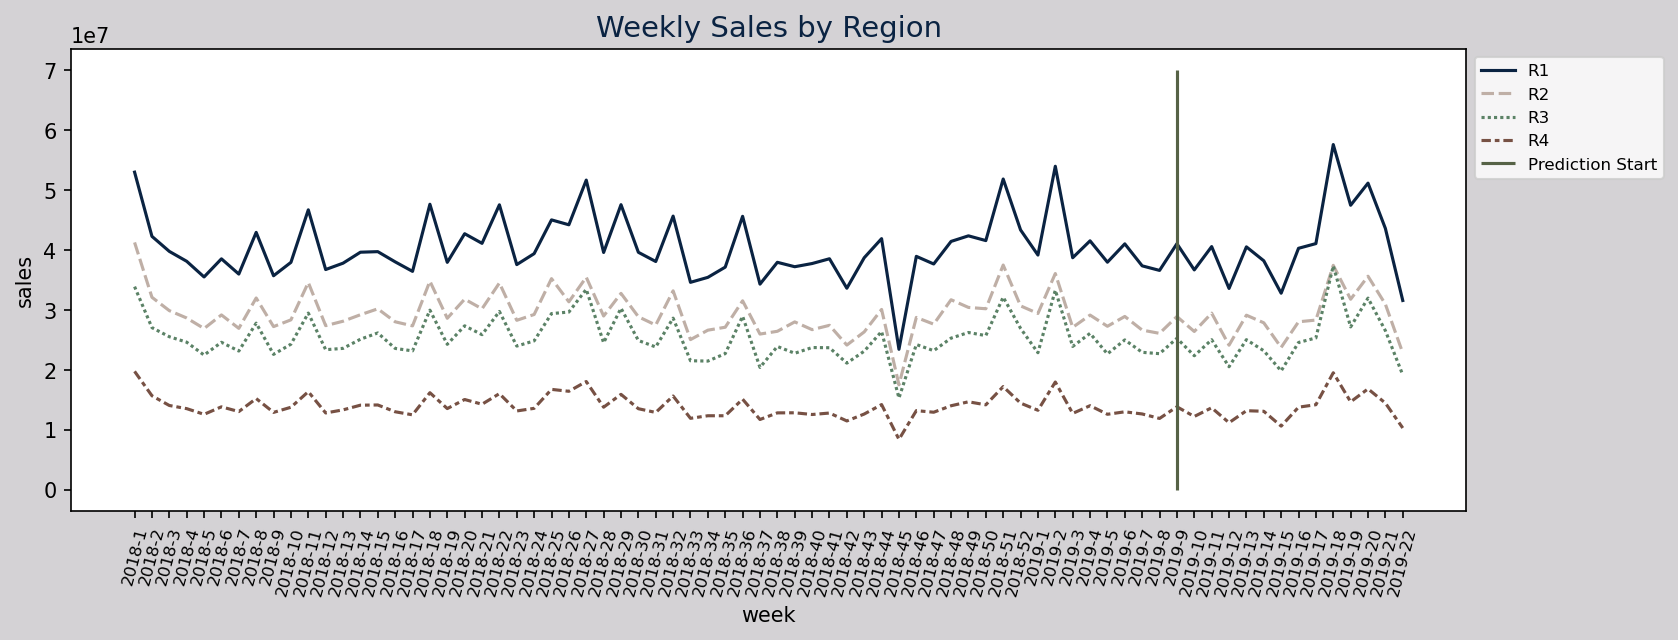

In [20]:
pal = [oxford_blue, silver, viridian, liver]
plt.figure(figsize=(12, 4), dpi=150, facecolor=timberwolf)
plt.title("Weekly Sales by Region", fontsize=14, color=oxford_blue)
sns.lineplot(weekly_df, x="week", y="sales", style="region_code", hue="region_code", palette=pal)
plt.xticks(rotation=75, fontsize=8)
plt.vlines(x="2019-9", ymin=0,ymax=70000000, colors=[ebony_green], label="Prediction Start")
plt.legend(bbox_to_anchor=(1, 1), ncol=1, fontsize=8);

##### We'll be using the data to the left of our vertical indicator line to predict the data to the right of the line.

___

## Baseline Model

We'll start by creating a baseline model that predicts the same value for each day in the next month. This will be our benchmark for evaluating the performance of our time series model.

In [21]:
baseline_sales = weekly_df[weekly_df['week'] < '2019-9']['sales'].mean()
baseline_pred = [baseline_sales for i in range(weekly_df[weekly_df['week'] >= '2019-9'].shape[0])]
baseline_rmse = np.sqrt(mean_squared_error(weekly_df[weekly_df['week'] >= '2019-9']['sales'], baseline_pred))
baseline_rmse

9696758.75141137

In [34]:
baseline_r2 = r2_score(weekly_df[weekly_df['week'] >= '2019-9']['sales'], baseline_pred)
baseline_r2

-3.939922745832547e-07

___

## Stationary Check: 

- In the context of time series analysis, stationarity refers to time series that have constant statistical properties (think mean, variance, etc.) over time. 

- Stationarity is an important concept in time series analysis because many powerful time series models like AMIRA work on the assumption that the time series is stationary. 
  
- In the case of a Linear Regression, the assumption of stationarity is not necessary, but it is still a good idea to check for stationarity. For this problem specifically, we are interested in stationarity because we have only 74 data points for each regional model, and the presence of stationarity gives us more confidence in our models to achieve reliable results under this restriction. 


For more information on stationarity, see: https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/


In [22]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(weekly_df['sales'])
print('p-value: %f' % result[1])

p-value: 0.008739


> In this case, the p-value is 0.008, which is less than the conventional significance level of 0.05. This means that there is strong evidence to reject the null hypothesis that the time series is non-stationary, and we can conclude that the time series is stationary at a high significance level. Good news!

___

## Adding Lagged Variables:

- Variable lagging is a common practice in time series analysis. The idea is to add "lagged" versions of the dependent variable, in this case the sales data, to the model.

- We accomplish this by creating a new column for each lagged variable, and then shifting the data in the column by the number of periods we want to lag the variable.

- Since our data is separated into regions, we will need to separate the data into regions and then lag the data for each region separately.

In [23]:
# Example: R1
lags = 8 # 8 weeks or roughly 2 months
lagged_df = weekly_df.loc[weekly_df.region_code=='R1'].copy()
for t in range(1, lags + 1):
    lagged_df[f'sales-{t}'] = lagged_df['sales'].shift(t)
print(lagged_df.shape)
lagged_df.head()

(74, 16)


,year,weekofyear,region_code,sales,orders,discounts,holidays,week,sales-1,sales-2,sales-3,sales-4,sales-5,sales-6,sales-7,sales-8
0,2018,1,R1,52925573.22,73891,674,124,2018-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018,2,R1,42225337.95,62244,246,124,2018-2,52925573.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2018,3,R1,39719301.00,67505,374,0,2018-3,42225337.95,52925573.22,NaN,NaN,NaN,NaN,NaN,NaN
12,2018,4,R1,38068777.05,64777,492,248,2018-4,39719301.00,42225337.95,52925573.22,NaN,NaN,NaN,NaN,NaN
16,2018,5,R1,35457822.42,62593,128,124,2018-5,38068777.05,39719301.00,42225337.95,52925573.22,NaN,NaN,NaN,NaN


> We will be implementing this process for each region in a function below

In [24]:
def linear_model_builder(df, lags, verbose=False):
    # initialize outputs
    models = []
    results = pd.DataFrame()
    predictions = []
    
    # Engineered Feature
    df['o2'] = df['orders'] ** 2
    
    for r_val in df['region_code'].unique():
        # creates a df for each region with weeks in order
        regional_df = df[df['region_code'] == r_val].copy()
        
        # Build lagged features
        for t in range(1, lags + 1):
            regional_df[f'sales-{t}'] = regional_df['sales'].shift(t)
        
        # Filter out the first few rows with NaNs from lagging
        lagged_df = regional_df.iloc[lags:, :]
        features = [f"sales-{t}" for t in range(1, lags + 1)] + \
            ["holidays", "discounts", "year", 'orders', 'o2']
        
        # Split into train and test    
        Xtrain, Xtest, ytrain, ytest = \
                            train_test_split(lagged_df[features], 
                                            lagged_df['sales'],
                                            test_size=0.2,
                                            random_state=42,
                                            shuffle=False)                    
        # Instantiate and fit model
        lr = LinearRegression()
        lr.fit(X=Xtrain, y=ytrain)
        
        # Evaluate model
        eval_dict = {
                'region': r_val,
                'train_r2': lr.score(Xtrain, ytrain),
                'test_r2': lr.score(Xtest, ytest),
                'train_rmse': np.sqrt(mean_squared_error(ytrain, lr.predict(Xtrain))),
                'test_rmse': np.sqrt(mean_squared_error(ytest, lr.predict(Xtest))),
                'mean_sales': lagged_df['sales'].mean(),
                'test_rmse_as_pct_of_mean_sales': np.sqrt(mean_squared_error(ytest, lr.predict(Xtest))) / lagged_df['sales'].mean(),
                'lag': lags
            }
        
        if verbose:    
            print(f"""
            Region: {r_val} with lag = {lags}, rows: {lagged_df.shape[0]}
            ________________________________________________________
            Train R2: {eval_dict['train_r2']:.3f}%, Train RMSE: {eval_dict['train_rmse']:.0f}
            Test R2: {eval_dict['test_r2']:.3f}%, Test RMSE: {eval_dict['test_rmse']:.0f}
            Mean of sales: {eval_dict['mean_sales']:.2f}
            Test RMSE as % of mean of sales: {eval_dict['test_rmse_as_pct_of_mean_sales']}%
            """, end="")
        
        # Append to outputs
        models.append(lr)
        results = pd.concat([results, pd.DataFrame(eval_dict, index=np.arange(1))])
        predictions.append(pd.DataFrame({
                                'region': r_val,
                                'date': regional_df['week'].iloc[-len(ytest):],
                                'ytest': ytest,
                                'ypred': lr.predict(Xtest)}))
    
    return models, results.reset_index(drop=True), pd.concat(predictions).reset_index(drop=True)

### Viewing the Results!

In [25]:
models, results, predictions = linear_model_builder(weekly_df, 4, verbose=True)


            Region: R1 with lag = 4, rows: 70
            ________________________________________________________
            Train R2: 0.770%, Train RMSE: 2400947
            Test R2: 0.946%, Test RMSE: 1598695
            Mean of sales: 40275771.73
            Test RMSE as % of mean of sales: 0.03969371446122899%
            
            Region: R2 with lag = 4, rows: 70
            ________________________________________________________
            Train R2: 0.760%, Train RMSE: 1640403
            Test R2: 0.902%, Test RMSE: 1255256
            Mean of sales: 29120374.16
            Test RMSE as % of mean of sales: 0.043105774952217554%
            
            Region: R3 with lag = 4, rows: 70
            ________________________________________________________
            Train R2: 0.792%, Train RMSE: 1498320
            Test R2: 0.956%, Test RMSE: 966983
            Mean of sales: 25132349.88
            Test RMSE as % of mean of sales: 0.03847563055279347%
            
      

In [26]:
results

,region,train_r2,test_r2,train_rmse,test_rmse,mean_sales,test_rmse_as_pct_of_mean_sales,lag
0,R1,0.769972,0.946108,2.400947e+06,1.598695e+06,4.027577e+07,0.039694,4
1,R2,0.760258,0.902143,1.640403e+06,1.255256e+06,2.912037e+07,0.043106,4
2,R3,0.792269,0.956072,1.498320e+06,9.669830e+05,2.513235e+07,0.038476,4
3,R4,0.772522,0.951098,8.176948e+05,5.134558e+05,1.374924e+07,0.037344,4


In [27]:
results['test_rmse'] < baseline_rmse

0    True
1    True
2    True
3    True
Name: test_rmse, dtype: bool

Interestingly, our test R2 values are all greater than our training R2 values. This is a good sign that our model is not overfitting to the training data. Additionally, our rmse values are all less than the baseline rmse value, telling us that our model is an improvement over random guessing.

___

## Scores as functions of Lag

Okay, so we might have a good model, but how do we know how many lags to use? Let's plot the Test RMSE as a function of the number of lags to see if we can find the optimal value.

In [28]:
# Generating a table of lag scores
lag_scores = pd.DataFrame()
for i in range(0,10):
    lag_scores = pd.concat([lag_scores, linear_model_builder(weekly_df, i)[1]])
lag_scores = lag_scores.reset_index(drop=True)
lag_scores.head()

,region,train_r2,test_r2,train_rmse,test_rmse,mean_sales,test_rmse_as_pct_of_mean_sales,lag
0,R1,0.687161,0.858974,2.876616e+06,2.534591e+06,4.043572e+07,0.062682,0
1,R2,0.658469,0.816717,2.107026e+06,1.686376e+06,2.932664e+07,0.057503,0
2,R3,0.720639,0.887745,1.789960e+06,1.508287e+06,2.527304e+07,0.059680,0
3,R4,0.703897,0.876914,9.982764e+05,8.023253e+05,1.385649e+07,0.057902,0
4,R1,0.747647,0.930033,2.467673e+06,1.785268e+06,4.026462e+07,0.044338,1


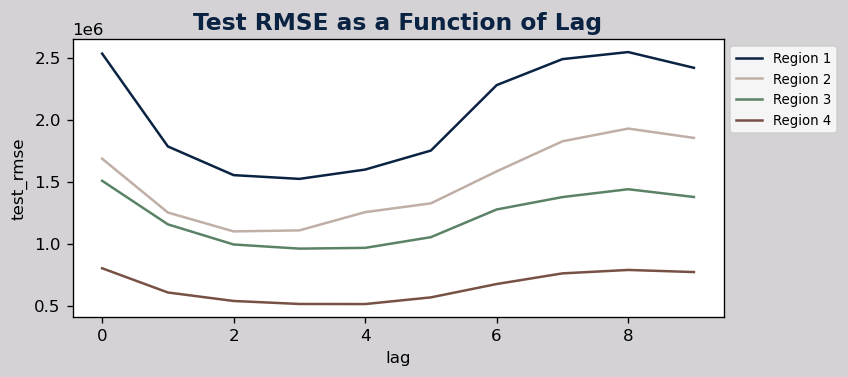

In [29]:
# Plot the test rmse as a function of lag for each regio
lag_palette = [oxford_blue, silver, viridian, liver]
plt.figure(figsize=(7,3), facecolor=timberwolf, dpi=120)
plt.title("Test RMSE as a Function of Lag", fontsize=14, color=oxford_blue, fontweight='semibold')
for i, region in enumerate(lag_scores['region'].unique()):
    sns.lineplot(lag_scores[lag_scores['region'] == region], x="lag", y=f"test_rmse", label=f"Region {region[1]}", c=lag_palette[i])
plt.legend(bbox_to_anchor=(1, 1), ncol=1, fontsize=8);   

It looks like our choice of 4 lags is a good one, though maybe slightly worse than 3. However, we will stick with 4 lags so that we can settle on predicting the next month of data.  

___

## Predicting the Next Month

In [30]:
predictions.head()

,region,date,ytest,ypred
0,R1,2019-9,40999983.24,4.194711e+07
1,R1,2019-10,36633752.34,3.625016e+07
2,R1,2019-11,40521879.00,4.191718e+07
3,R1,2019-12,33545814.93,3.450079e+07
4,R1,2019-13,40473579.00,4.030234e+07


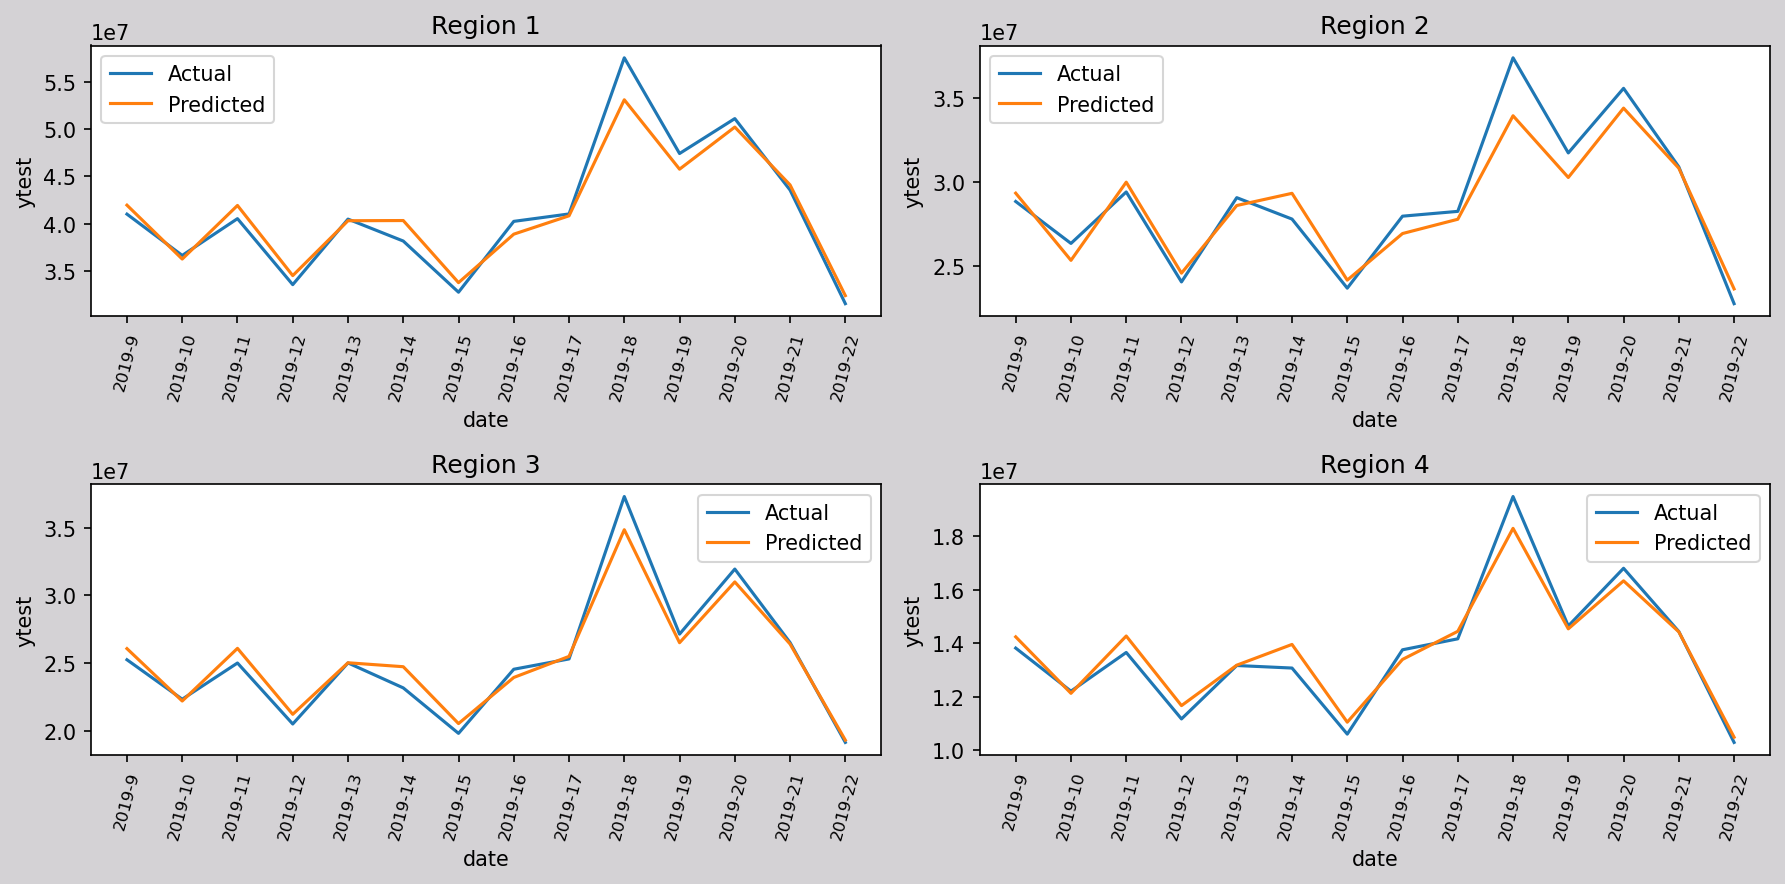

In [31]:
from matplotlib.ticker import FixedFormatter, FixedLocator

fig, ax = plt.subplots(2, 2, figsize=(12, 6), dpi=150, facecolor=timberwolf)
ax = ax.flatten()

for i, region in enumerate(predictions['region'].unique()):
    sns.lineplot(data=predictions[predictions['region'] == region], x="date", y="ytest", ax=ax[i], label=f"Actual")
    sns.lineplot(data=predictions[predictions['region'] == region], x="date", y="ypred", ax=ax[i], label=f"Predicted")
    ax[i].set_title(f"Region {region[1]}")
    ax[i].xaxis.set_major_locator(FixedLocator(range(len(predictions[predictions['region'] == region]['date']))))
    ax[i].xaxis.set_major_formatter(FixedFormatter(predictions[predictions['region'] == region]['date'].tolist()))
    ax[i].tick_params(axis='x', rotation=75, labelsize=8)
fig.set_tight_layout(True)

## Incredible!

We have a model that can predict the next month of data with shocking accuracy for its simplicity. Further analysis could be conducted to understand the drivers of the model outside of the time series data, but for now, we will leave it at this.

___